# Analysis Notebook

## In this notebook, we do some exploratory data visualisation. The aim of this exploration is to see these things:
## * How much of role has expenditure on transfers played since 1992
## * How much value have managers extracted from their players considering their limitations? Namely, which are the best and worst ones.

### First the imports:


In [189]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# show all columns
pd.set_option('display.max_columns', None)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [191]:
# %%R

# install.packages("zoo")

In [192]:
%%R 

require('tidyverse')
require('tidyr')
require('stringr')
require('zoo')
require('dplyr')


# Load and clean data

### The two databases are points in every year since the Premier League started and the total money acquired in each year by every Premiership Club, to see how the database was compiled, take a look at the compile notebook. Some cleaning has already taken place. The main aim behind the cleaning is to ensure a cleaner join.

In [254]:
# Load data

points = pd.read_csv('points.csv')
display(points.head(5))

fees = pd.read_csv('fees.csv')
display(fees.head(5))


,Squad,Pts_2023,Pts_2022,Pts_2021,Pts_2020,Pts_2019,Pts_2018,Pts_2017,Pts_2016,Pts_2015,Pts_2014,Pts_2013,Pts_2012,Pts_2011,Pts_2010,Pts_2009,Pts_2008,Pts_2007,Pts_2006,Pts_2005,Pts_2004,Pts_2003,Pts_2002,Pts_2001,Pts_2000,Pts_1999,Pts_1998,Pts_1997,Pts_1996,Pts_1995,Pts_1994,Pts_1993,Pts_1992,Total_Pts
0,Arsenal,81.0,69.0,61.0,56.0,70.0,63.0,75.0,71.0,75.0,79.0,73.0,70.0,68.0,75.0,72.0,83.0,68.0,67.0,83.0,90.0,78.0,87.0,70.0,73.0,78.0,78.0,68.0,63.0,51.0,71.0,56.0,72.0,2294.0
1,Aston Villa,54.0,45.0,55.0,35.0,NaN,NaN,NaN,17.0,38.0,38.0,41.0,38.0,48.0,64.0,62.0,60.0,50.0,42.0,47.0,56.0,45.0,50.0,54.0,58.0,55.0,57.0,61.0,63.0,48.0,57.0,74.0,60.0,1472.0
2,Bournemouth,39.0,NaN,NaN,34.0,45.0,44.0,46.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250.0
3,Brentford,50.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.0
4,Brighton,55.0,51.0,41.0,41.0,36.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.0


,club_name,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AFC Bournemouth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.055,4.82,55.11,40.690,34.300,91.60,54.91,0.00,12.64,83.10
1,Arsenal,4.60,1.28,7.18,18.350,6.11,22.025,15.95,25.4,56.30,32.685,12.830,27.425,12.48,46.00,15.000,30.95,40.15,12.00,23.00,65.480,56.00,49.250,118.98,26.50,113.000,152.850,80.15,160.80,86.00,167.40,192.36
2,Aston Villa,3.93,4.25,7.34,11.067,8.10,10.500,42.80,9.6,21.12,26.100,9.080,8.380,10.14,16.54,24.700,24.90,55.90,46.90,37.40,20.335,27.83,19.840,13.45,66.55,85.500,2.800,19.10,159.50,101.35,129.80,100.14
3,Barnsley,NaN,NaN,NaN,NaN,NaN,6.937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.625,3.84,2.34,2.34,2.71,1.290,0.00,0.545,NaN,NaN,2.540,6.385,NaN,6.35,3.00,1.20,NaN
4,Birmingham City,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.685,17.100,15.77,8.10,20.430,29.30,3.50,20.05,25.60,0.570,0.32,0.000,0.00,3.04,10.085,17.650,2.50,10.28,8.34,0.00,0.00


In [255]:
%%R -i points,fees

# pivot longer

points <- points %>% 
    pivot_longer(cols=-Squad, names_to='year', values_to='points') %>% 
    mutate(year = as.integer(str_replace(year, 'Pts_', ''))) %>%
    mutate(Squad = str_replace(Squad, 'Nott\'ham Forest', 'Nottingham Forest')) 


fees <- fees %>% 
  pivot_longer(cols = -club_name, values_to='fees') %>% 
  mutate(year = as.integer(name)) %>% 
  select(-name) %>% # drops name column
  mutate(club_name = str_replace_all(club_name, c('AFC ' = '', 
                                                  ' AFC' = '',
                                                    ' & Hove Albion' = '', 
                                                    'Huddersfield Town' = 'Huddersfield', 
                                                    'Tottenham Hotspur' = 'Tottenham',
                                                    'Blackburn Rovers' = 'Blackburn',
                                                    'West Bromwich Albion' = 'West Brom', 
                                                    'West Ham United' = 'West Ham',
                                                    'Charlton Athletic' = 'Charlton Ath')))



In [256]:
%%R -o points_clubs,fees_clubs
points_clubs <- points %>% select(Squad)  %>% arrange(Squad) %>% unique()
fees_clubs <- fees %>% select(club_name) %>% arrange(club_name) %>% unique()


## The Join

In [257]:
%%R -o df

# merge fees and points on club_name and Squad respectively
df <- fees %>% merge(points, by.x = c('club_name','year'), by.y = c('Squad','year')) 
df %>% head()


  club_name year   fees points
1   Arsenal 1992  4.600     72
2   Arsenal 1993  1.280     56
3   Arsenal 1994  7.180     71
4   Arsenal 1995 18.350     51
5   Arsenal 1996  6.110     63
6   Arsenal 1997 22.025     68


# Analysis

### A few methodological choices:

1. We are going to create two new columns in our joined dataframe called fees_4 and points_4_avg


| fees_4 | The rolling sum of the past four seasons of expenditure. For eg; 1997 will have the sum of 1997, 1996, 1995 and 1994. |
| --- | --- |
| points_4_avg | the average number of points in the 4 seasons leading upto the listed season. For eg; 1997 will have the average points of 1997, 1996, 1995 and 1994. |



In [258]:
%%R -o df

# TODO  - make sure that if a year is mising, it is rollmeanr is dividing by 3 and not 4
# calculate a column that is fees from the last 4 years of a club
df <- df %>% 
    group_by(club_name) %>%
    mutate(
        fees_4 = rollsumr(fees, 4, fill = NA),
        points_4_avg = rollmeanr(points, 4, fill = NA)
    ) %>%
    ungroup() %>% 
    filter(year > 1991)

df

# A tibble: 1,581 × 6
   club_name  year  fees points fees_4 points_4_avg
   <chr>     <int> <dbl>  <dbl>  <dbl>        <dbl>
 1 Arsenal    1992  4.6      72   NA           NA  
 2 Arsenal    1993  1.28     56   NA           NA  
 3 Arsenal    1994  7.18     71   NA           NA  
 4 Arsenal    1995 18.4      51   31.4         62.5
 5 Arsenal    1996  6.11     63   32.9         60.2
 6 Arsenal    1997 22.0      68   53.7         63.2
 7 Arsenal    1998 16.0      78   62.4         65  
 8 Arsenal    1999 25.4      78   69.5         71.8
 9 Arsenal    2000 56.3      73  120.          74.2
10 Arsenal    2001 32.7      70  130.          74.8
# ℹ 1,571 more rows
# ℹ Use `print(n = ...)` to see more rows


In [259]:
df

,club_name,year,fees,points,fees_4,points_4_avg
1,Arsenal,1992,4.600,72.0,NaN,NaN
2,Arsenal,1993,1.280,56.0,NaN,NaN
3,Arsenal,1994,7.180,71.0,NaN,NaN
4,Arsenal,1995,18.350,51.0,31.410,62.50
5,Arsenal,1996,6.110,63.0,32.920,60.25
...,...,...,...,...,...,...
1577,Wolverhampton Wanderers,2018,112.750,NaN,182.804,NaN
1578,Wolverhampton Wanderers,2019,116.700,57.0,290.160,NaN
1579,Wolverhampton Wanderers,2020,87.589,59.0,341.649,NaN
1580,Wolverhampton Wanderers,2021,37.600,45.0,354.639,NaN


`geom_smooth()` using formula = 'y ~ x'


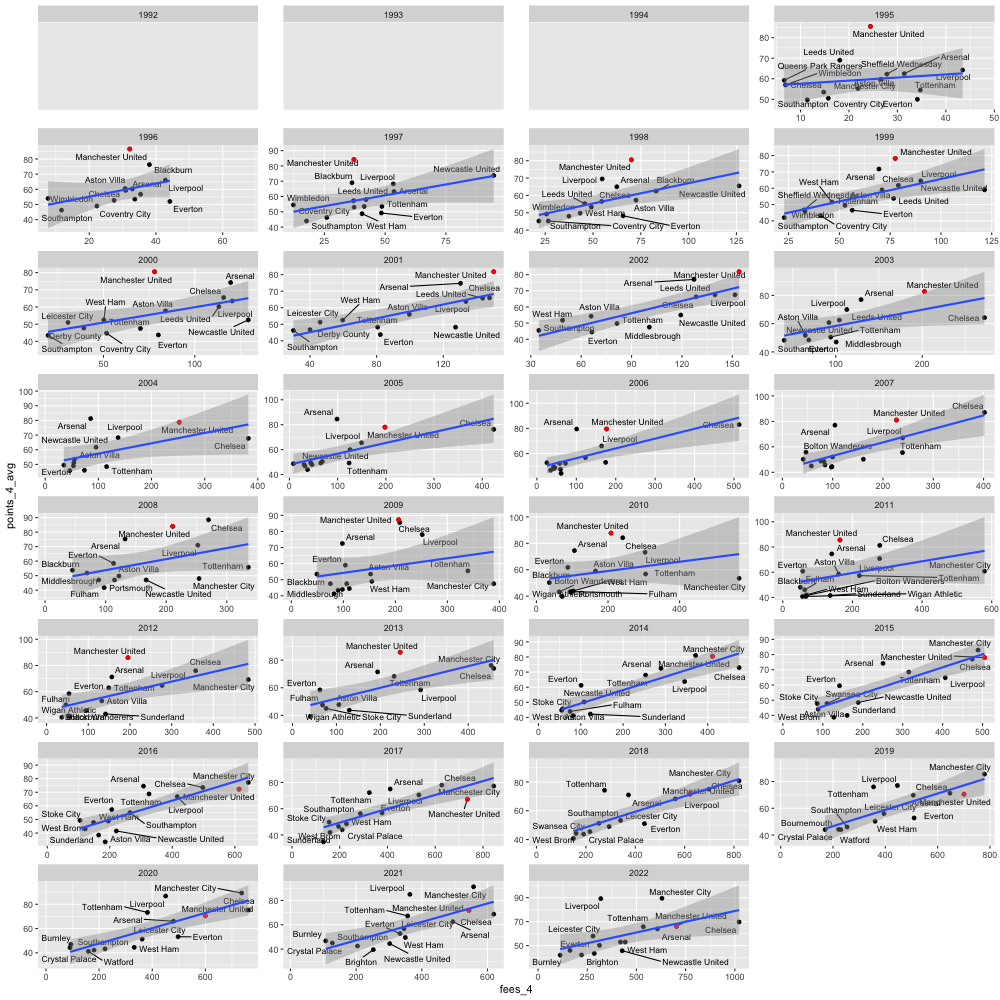

In [260]:
%%R -w 1000 -h 1000
# Exploratory data analysis

require('ggrepel')

ggplot(df) +
    aes(x=fees_4, y=points_4_avg) +
    geom_point() +
    geom_text_repel(aes(label=club_name), size=3) +
    geom_point(data = df %>% filter(club_name == "Manchester United"), color='red') +
    geom_smooth(method='lm') +
    facet_wrap(~year, ncol=4, scales='free')


In [243]:
%%R -o df_without_na

# loop through each year and fit a linear model
df_without_na <- df %>% 
            filter(!is.na(fees_4)) %>% 
            filter(!is.na(points)) 

In [244]:
df_without_na

,club_name,year,fees,points,fees_4,points_4_avg
1,Arsenal,1995,18.350,51.0,31.410,62.50
2,Arsenal,1996,6.110,63.0,32.920,60.25
3,Arsenal,1997,22.025,68.0,53.665,63.25
4,Arsenal,1998,15.950,78.0,62.435,65.00
5,Arsenal,1999,25.400,78.0,69.485,71.75
...,...,...,...,...,...,...
490,Wolverhampton Wanderers,2012,15.330,25.0,67.045,NaN
491,Wolverhampton Wanderers,2019,116.700,57.0,290.160,NaN
492,Wolverhampton Wanderers,2020,87.589,59.0,341.649,NaN
493,Wolverhampton Wanderers,2021,37.600,45.0,354.639,NaN


In [245]:
%%R -o df_r_squared,df_years

# create empty dataframe
df_r_squared <- data.frame(
    year = integer(), 
    r_squared = numeric(),
    pvalue = numeric()
    )

df_years <- data.frame(
    club_name = character(),
    year = integer(),
    fees = numeric(),
    points = numeric(),
    fees_4 = numeric(),
    points_4_avg = numeric(),
    residuals = numeric(),
    residuals_z = numeric()
)

for (y in unique(df_without_na$year)) {

    df_year <- df_without_na %>%
                filter(year == y)

    # fit linear model
    model <- lm(points ~ fees_4, data = df_year)
    
    # get r-squared
    r_sqared <- summary(model)$r.squared

    # get pvalue of model
    pval <- summary(model)$coefficients[2,4]

    # add to df_r_squared
    df_r_squared <- df_r_squared %>% add_row(year = y, r_squared = r_sqared, pvalue=pval)

    #### ADD RESIDUALS TO df_year
    df_year <- df_year %>% 
        mutate(
            residuals = residuals(model),
            residuals_z = (residuals - mean(residuals)) / sd(residuals)
        )

    # add df_year to df_years
    df_years <- df_years %>% add_row(df_year)
}


## THESE ARE THE DFS WE JUST MADE
# df_r_squared
# df_years

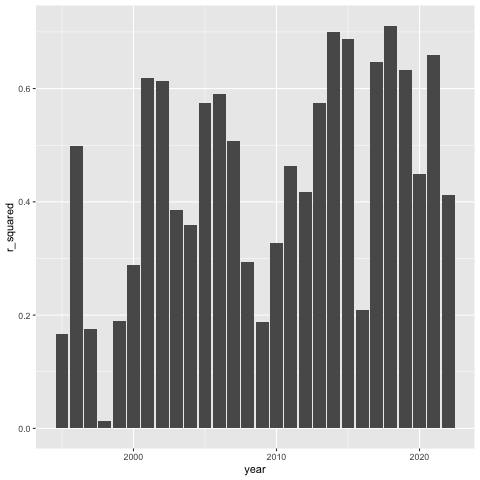

In [246]:
%%R 

ggplot(df_r_squared) + 
    aes(x=year, y=r_squared) +
    geom_col()

In [247]:
df_years

,club_name,year,fees,points,fees_4,points_4_avg,residuals,residuals_z
1,Arsenal,1995,18.350,51.0,31.410,62.50,-12.781739,-1.007492
2,Aston Villa,1995,11.067,48.0,26.587,59.75,-13.594229,-1.071534
3,Blackburn,1995,16.500,89.0,47.968,NaN,17.708250,1.395813
4,Chelsea,1995,1.900,54.0,14.795,53.50,-2.245875,-0.177026
5,Coventry City,1995,6.250,50.0,15.730,50.50,-6.669951,-0.525744
...,...,...,...,...,...,...,...,...
490,Southampton,2022,143.650,40.0,285.550,43.50,-7.498327,-0.505361
491,Tottenham,2022,177.900,71.0,534.800,65.75,10.385622,0.699955
492,Watford,2022,18.810,23.0,118.310,NaN,-15.697812,-1.057978
493,West Ham,2022,194.000,56.0,443.000,53.00,0.216328,0.014580


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


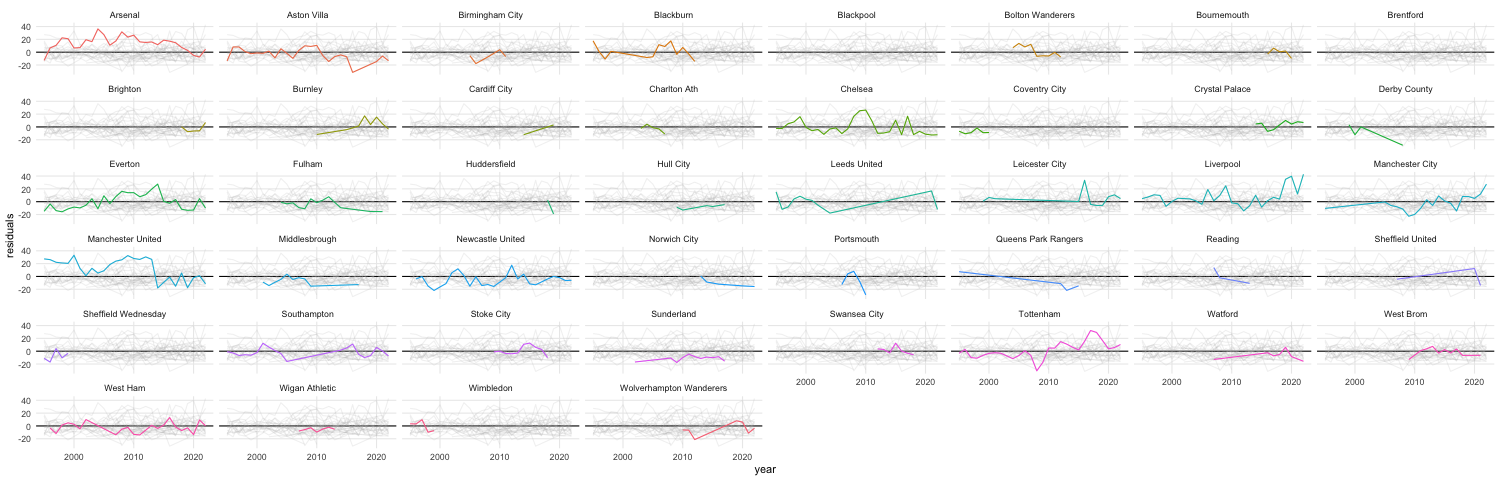

In [248]:
%%R -w 1500

background_data <- df_years %>% 
    mutate(club_name_2 = club_name) %>%
    select(-club_name)


ggplot(df_years) +
    aes(x=year, y=residuals, color=club_name) +
    geom_hline(aes(yintercept=0)) +
    geom_line(data = background_data, aes(group=club_name_2), color='grey', alpha=.2) +
    geom_line() +
    facet_wrap(~club_name, ncol=8) +
    theme_minimal() +
    theme(
        legend.position = "none",
        panel.grid.minor = element_blank(),
    ) 



In [249]:
# To do next

# - run regressions for each year y=points_4_avg , x=fees_4
# - look at r^2 of those for each year and p-values
# - residuals for each club over time
